In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

validation_size = 2000
test_size = len(test_dataset) - validation_size

validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

60000 2000 8000


In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

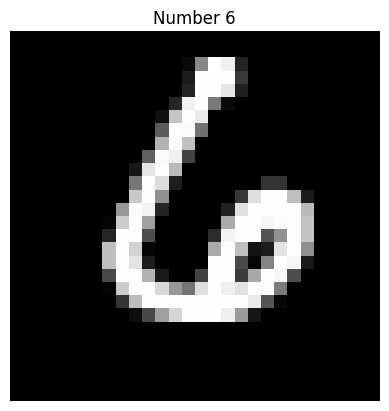

In [ ]:
data_iter = iter(train_loader)
img, label = next(data_iter)
img = img[0, 0]

plt.imshow(img, cmap='grey')
plt.title(f"Number {label[0]}")
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class myCNN(nn.Module):
  def __init__(self):
    super(myCNN, self).__init__()
    # Dimensions: 1x28x28 -> 32x28x28
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    # Dimensions: 32x28x28 -> 32x14x14
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    # Dimensions: 32x14x14 -> 64x14x14
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    # Danach nochmal Pooling Layer: 64x14x14 --> 64x7x7
    self.dropout = nn.Dropout(0.25)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(64*7*7, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)

    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
import torch.optim as optim

model = myCNN().to(device)
print(model)

learning_rate = 0.001
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

myCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  acc_loss = 0
  acc_count = 0
  model.train()
  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------")
    for batch, (X, y) in enumerate(train_loader):
      X = X.to(device)
      y = y.to(device)

      pred = model(X)
      loss = criterion(pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      acc_loss += loss.item()
      acc_count += 1

    model.eval()
    correct = 0

    with torch.no_grad():
      for X, y in val_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        correct += (pred.argmax(1)==y).sum().item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {acc_loss/acc_count}, Validation Accuracy: {correct/validation_size:.2%}\n")

In [ ]:
def test_model(model, test_loader, criterion):
  model.eval()
  correct = 0

  with torch.no_grad():
    for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss = criterion(pred, y)
      correct += (pred.argmax(1)==y).sum().item()
    print(f"Overall test accuracy: {correct/test_size:.2%}")

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1
-------------------
Epoch [1/5], Loss: 0.17568533338391895, Validation Accuracy: 98.50%

Epoch 2
-------------------
Epoch [2/5], Loss: 0.11159170459971321, Validation Accuracy: 98.60%

Epoch 3
-------------------
Epoch [3/5], Loss: 0.08558105563253178, Validation Accuracy: 99.25%

Epoch 4
-------------------
Epoch [4/5], Loss: 0.07020361993403763, Validation Accuracy: 98.70%

Epoch 5
-------------------
Epoch [5/5], Loss: 0.05984859789663119, Validation Accuracy: 98.95%



In [ ]:
# Not trained model
print(f"Not trained model:")
model_not_trained = myCNN().to(device)
test_model(model_not_trained, test_loader, criterion)

# Our trained model
print(f"Our trained model:")
test_model(model, test_loader, criterion)

Not trained model:
Overall test accuracy: 10.09%
Our trained model:
Overall test accuracy: 99.02%


In [ ]:
# Save model
model_path = "model_weights.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
# Run test on saved pre trained model
model_pre_trained = myCNN().to(device)
model_pre_trained.load_state_dict(torch.load(model_path))

test_model(model_pre_trained, test_loader, criterion)

<ipython-input-14-2aa716e0eb9d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pre_trained.load_state_dict(torch.load(model_path))


Overall test accuracy: 99.02%


In [ ]:
!pip install torch-summary
from torchsummary import summary
summary(model_pre_trained, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Dropout: 1-4                           --
├─ReLU: 1-5                              --
├─Linear: 1-6                            401,536
├─Linear: 1-7                            1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Dropout: 1-4                           --
├─ReLU: 1-5                              --
├─Linear: 1-6                            401,536
├─Linear: 1-7                            1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0